My goal for this project is to be able to extract, transform, and load data from the Riot API. After cleaning the data, I want to analyze the data through filtering, visualiztions and machine learning models. To do this, I need to make this reproducible. I can do this with the following functions. Using these functions, I can pull data from any player that has played a ranked game of league of legends with only needing their name and region. I can then use the dataframe to filter, analyze and learn more about the player. I can create visualizations and machine learning models to create predictive models.

To start this project I need to import requests to be able to request from the Riot API. I also have a separate file that stores my key to make requests to the Riot API. That way I can keep my key private. I am going to be using numpy and pandas as my way of storing the data in a dataframe after pulling it.

In [1]:
import requests, json
import pandas as pd
import numpy as np
import riot_API_key
#packages I need for this project

riotwatcher is a wrapper that goes over the Riot API to make requests easier. Riot API also only allows 100 requests every 2 minutes, so riotwatcher buffers the requests to make sure I am not pulling too many and getting blacklisted.

In [2]:
pip install riotwatcher

Note: you may need to restart the kernel to use updated packages.


In [3]:
from riotwatcher import LolWatcher, ApiError
#wrapper for Riot API

To get my data from the API, I need a few basic pieces of info. For this project, I am using my own personal league account, TingaTaco, as the example. I need the name of my account(summonerId), my key to make requests, and the region that I am located(na1/north america). Some calls require the region and some require the country, so I have both listed. For this specific project, I want only my ranked games as there are multiple different game modes that can be played. I specify this with the 'ranked' string.

In [4]:
lol_watcher = LolWatcher(riot_API_key.my_key)
#using my key in the riotwatcher wrapper
summonerid = 'TingaTaco'
#my own personal account
mykey = riot_API_key.my_key
#my key
my_region = 'na1'
region = 'americas'
#regions to make the calls
ranked = 'ranked'
#only want my ranked games

This first function requires a name and region to pull the rest of the account information. This information is useful to pull the match history.

In [5]:
def get_account_info(region,summonerid):
    #input my region and summonerId to get the rest of my account info
    summoner = lol_watcher.summoner.by_name(region,summonerid)
    return summoner
    #summoner will store all my account info
    
    
summonerInfo = get_account_info(my_region,summonerid)
#I save this function as summonerInfo

This next function pulls the list of match ids that I need to access the data within each match. The input variables I need to enter for this function are my region and player id(puuid). I get my player id through the account info function above. The other requirements are count and type. The count pulls how many match ids I want to get. The default is 10, but I am able to pull up to 100 match ids for any given player. That many matches can provide a ton of data, and takes a couple of minutes to make such a large request. The type input is the type of game mode I am looking to pull. This default is null and will pull any match starting from the most recent. To keep this project consistent, I only want my ranked matches. 

In [6]:
def get_match_list(region,puuid,count,type):
    #inputs my region, playerid, number of games I want, and the type of game mode I want to pull
    matches = lol_watcher.match.matchlist_by_puuid(region,puuid,count=count,type=type)
    #request match ids from riot
    return matches
    
matchNum = get_match_list(region,summonerInfo['puuid'],5,ranked)
#matchNum will store my match history

The get_match_info is the bulk of this project's data gathering. From the match numbers I pulled in the the get_match_list function, I iterate through each of those matches in this function. For each match that I am iterating though, I want to pull data on a specific player level. This can be done through for loops that allow me to iterate through each player in the match. This means for each game, I am pulling data for all 10 players and putting the data in a dictionary called participant_row. At this step, I am gathering as much info that I think could be useful from each individual game that might help with future analysis. For each game, I expect 10 rows of data(5 players for each team). Each game will be categorized by the match/game ids specific for that given game. Some rows I am pulling are key columns that are used to identify each match, and other rows are data intensive rows that give insights on how the game went. The final row I am pulling is the win category that reveals the results of the game. A 1 in the in win column would signify a win and a 0 would then be a loss. The win column is my dependent variable, and I will use all the other rows to be able to predict the win category later in this project. 

In [7]:
def get_match_info(region,matchNum):
    #Iterates through each match and pull the data from a player level
    matchInfo = []
    #Initiate an empty list to add my dictionary of data to at the end of this function
    for match in matchNum:
    #Iterate through each match number individually
        matches = lol_watcher.match.by_id(region,match)
        #Pull data from each match
        for each in matches['info']['participants']:
        #Go down to the participant level to pull data from each player
            participants_row = {}
            #Initialize a dictionary to create key:value pairs of the data where the key is the column and the value is the data
            participants_row['matchId'] = matches['metadata']['matchId']
            participants_row['gameId'] = matches['info']['gameId']
            participants_row['gameDuration'] = matches['info']['gameDuration']
            participants_row['gameVersion'] = (matches['info']['gameVersion'])[0:4]
            #I only want the first 4 letters of the string for game version. Ex. patch(12.5) is the version I played on
            participants_row['champion'] = each['championId']
            participants_row['assists'] = each['assists']
            participants_row['championName'] = each['championName']
            participants_row['level'] = each['champLevel']
            participants_row['damageSelfMitigated'] = each['damageSelfMitigated']
            participants_row['deaths'] = each['deaths']
            participants_row['goldEarned'] = each['goldEarned']
            participants_row['role'] = each['individualPosition']
            participants_row['position'] = each['teamPosition']
            participants_row['kills'] = each['kills']
            participants_row['participantId'] = each['participantId']
            participants_row['puuid'] = each['puuid']
            participants_row['summonerSpell1'] = each['summoner1Id']
            participants_row['summonerSpell2'] = each['summoner2Id']
            participants_row['summonerId'] = each['summonerId']
            participants_row['summonerName'] = each['summonerName']
            participants_row['totalDamageToChamps'] = each['totalDamageDealtToChampions']
            participants_row['totalDamageTaken'] = each['totalDamageTaken']
            participants_row['totalHeal'] = each['totalHeal']
            participants_row['totalHealsOnTeammates'] = each['totalHealsOnTeammates']
            participants_row['totalDamageShielded'] = each['totalDamageShieldedOnTeammates']
            participants_row['CS'] = each['totalMinionsKilled']
            participants_row['totalTimeCCDealt'] = each['totalTimeCCDealt']
            participants_row['visionScore'] = each['visionScore']
            participants_row['wardsKilled'] = each['wardsKilled']
            participants_row['wardsPlaced'] = each['wardsPlaced']
            participants_row['item1'] = each['item0']
            participants_row['item2'] = each['item1']
            participants_row['item3'] = each['item2']
            participants_row['item4'] = each['item3']
            participants_row['item5'] = each['item4']
            participants_row['item6'] = each['item5']
            participants_row['item7'] = each['item6']
            participants_row['goldPerMin'] = round(each['challenges']['goldPerMinute'])
            #Round the gold per minute to a whole number
            participants_row['jgCsBefore10Min'] = each['challenges']['jungleCsBefore10Minutes']
            participants_row['kda'] = round(each['challenges']['kda'],2)
            #Provide 2 decimal points for kill participation, kda, and vision score per min
            participants_row['kp'] = round(each['challenges']['killParticipation'],2)
            participants_row['laneMinionsFirst10Minutes'] = each['challenges']['laneMinionsFirst10Minutes']
            participants_row['teamBaronKills'] = each['challenges']['teamBaronKills']
            participants_row['teamElderDragonKills'] = each['challenges']['teamElderDragonKills']
            participants_row['teamRiftHeraldKills'] = each['challenges']['teamRiftHeraldKills']
            participants_row['turretPlatesTaken'] = each['challenges']['turretPlatesTaken']
            participants_row['visionScorePerMin'] = round(each['challenges']['visionScorePerMinute'],2)
            participants_row['win'] = each['win']
            matchInfo.append(participants_row)
            #append the entire dictionary to a list
    return(matchInfo)


match_df = get_match_info(region,matchNum)

The match_items function as well as the match_summoner_spell function provide decoding from the Riot API. Items that are purchased in game are coded in numbers that correlate to the name of the items. This is all stored as static data in a file called the Data Dragon on Riot's API website. Calling the file from the Data Dragon specific for items allows me to match the items purchased in each game to the names of the items. A player can have up to 7 items in each game, so I need to pull each item a player has and replace the number with the actual name of the item. I do the same steps with the summoner spells that a player has in each game. This is pulled through the Data Dragon file specific to summoner spells, but matched up very much like the match_items function. 

In [8]:
def match_items(region):
    #Match item numbers to item names
    latest_item = lol_watcher.data_dragon.versions_for_region(region)['n']['item']
    #This gets the latest version of the Data Dragon
    item_list = lol_watcher.data_dragon.items(latest_item,'en_US')
    #This pulls the list of items from the Data Dragon in English
    
    itemDict = {}
    #Create a dictionary to store the item numbers as keys and the names as values
    itemDict['0'] = 'None'
    #Some players do not have 7 items at the end of the game. This dictionary item fills the empty slots with None
    for item in item_list['data']:
        itemDict[item] = item_list['data'][item]['name']
    
    for row in match_df:
#         print(str(row['item1']) + ' ' + itemDict[str(row['item1'])])
        row['item1'] = itemDict[str(row['item1'])]
        row['item2'] = itemDict[str(row['item2'])]
        row['item3'] = itemDict[str(row['item3'])]
        row['item4'] = itemDict[str(row['item4'])]
        row['item5'] = itemDict[str(row['item5'])]
        row['item6'] = itemDict[str(row['item6'])]
        row['item7'] = itemDict[str(row['item7'])]
        #This matches each item in each player's inventory to the name of the items and changes them
match_items(my_region)

This summoner_spell function is similar to the item function above. This matches the summoner spells ids from the game to the actual names of the summoner spells through the Data Dragon. 

In [9]:
def match_summoner_spells(region):
    #Match summoner spells ids to the names for each player
    latest_summoners = lol_watcher.data_dragon.versions_for_region(my_region)['n']['summoner']
    #Get the latest version of the summoner spell file in the Data Dragon
    ss_list = lol_watcher.data_dragon.summoner_spells(latest_summoners,'en_US')
    #Get the list of summoner spells in English
    
    ssDict = {}
    for name in ss_list['data']:
        summonerNames = []
        summonerNames.append(name)
        for each in summonerNames:
            ssDict[ss_list['data'][each]['key']] = ss_list['data'][each]['name']
    #Create a dictionary to store the summoner spell ids as keys and the names as values
    
    for row in match_df:
#         print(str(row['summonerSpell1']) + ' ' + ssDict[str(row['summonerSpell1'])])
        row['summonerSpell1'] = ssDict[str(row['summonerSpell1'])]
        row['summonerSpell2'] = ssDict[str(row['summonerSpell2'])]
        #This matches each summoner spell to the respective name for every player

match_summoner_spells(my_region)

Now that all the data is gathered, I move the data to a dataframe to visualize the data. I view a portion of the data with the head function to make sure the dataframe was made correctly.

In [10]:
df = pd.DataFrame(match_df)
df.head()

,matchId,gameId,gameDuration,gameVersion,champion,assists,championName,level,damageSelfMitigated,deaths,...,jgCsBefore10Min,kda,kp,laneMinionsFirst10Minutes,teamBaronKills,teamElderDragonKills,teamRiftHeraldKills,turretPlatesTaken,visionScorePerMin,win
0,NA1_4251735878,4251735878,1580,12.5,23,3,Tryndamere,15,15515,7,...,0.0,2.14,0.48,65,1,0,2,5,0.30,True
1,NA1_4251735878,4251735878,1580,12.5,32,13,Amumu,14,26560,6,...,68.0,3.50,0.68,0,1,0,2,3,0.74,True
2,NA1_4251735878,4251735878,1580,12.5,246,6,Qiyana,14,8553,6,...,0.0,2.17,0.42,67,1,0,2,5,0.58,True
3,NA1_4251735878,4251735878,1580,12.5,81,11,Ezreal,13,5667,7,...,0.0,3.14,0.71,48,1,0,2,3,0.36,True
4,NA1_4251735878,4251735878,1580,12.5,147,14,Seraphine,13,6176,5,...,0.0,3.40,0.55,4,1,0,2,6,2.13,True


This next step is some additional cleaning to make the data easier to use. I make all the character strings lowercase, and change the roles for the given players. The utility player is usually called the support and the bottom is usually called the attack damage carry(adc). I also change the win column from true/false to 1/0 for future analysis. 

In [11]:
df = df.applymap(lambda s: s.lower() if type(s) == str else s)
df['role'] = df['role'].str.replace('utility','support')
df['role'] = df['role'].str.replace('bottom','adc')
df['position'] = df['position'].str.replace('utility','support')
df['position'] = df['position'].str.replace('bottom','adc')
df['win'] = df['win'].astype(int)

I then pull the head of the df again to make sure everything looks correct. I also look at the column names since there are so many. I also use the describe function to learn a little about my dataset at a glance.

In [12]:
df.head()

,matchId,gameId,gameDuration,gameVersion,champion,assists,championName,level,damageSelfMitigated,deaths,...,jgCsBefore10Min,kda,kp,laneMinionsFirst10Minutes,teamBaronKills,teamElderDragonKills,teamRiftHeraldKills,turretPlatesTaken,visionScorePerMin,win
0,na1_4251735878,4251735878,1580,12.5,23,3,tryndamere,15,15515,7,...,0.0,2.14,0.48,65,1,0,2,5,0.30,1
1,na1_4251735878,4251735878,1580,12.5,32,13,amumu,14,26560,6,...,68.0,3.50,0.68,0,1,0,2,3,0.74,1
2,na1_4251735878,4251735878,1580,12.5,246,6,qiyana,14,8553,6,...,0.0,2.17,0.42,67,1,0,2,5,0.58,1
3,na1_4251735878,4251735878,1580,12.5,81,11,ezreal,13,5667,7,...,0.0,3.14,0.71,48,1,0,2,3,0.36,1
4,na1_4251735878,4251735878,1580,12.5,147,14,seraphine,13,6176,5,...,0.0,3.40,0.55,4,1,0,2,6,2.13,1


In [13]:
df.columns

Index(['matchId', 'gameId', 'gameDuration', 'gameVersion', 'champion',
       'assists', 'championName', 'level', 'damageSelfMitigated', 'deaths',
       'goldEarned', 'role', 'position', 'kills', 'participantId', 'puuid',
       'summonerSpell1', 'summonerSpell2', 'summonerId', 'summonerName',
       'totalDamageToChamps', 'totalDamageTaken', 'totalHeal',
       'totalHealsOnTeammates', 'totalDamageShielded', 'CS',
       'totalTimeCCDealt', 'visionScore', 'wardsKilled', 'wardsPlaced',
       'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'item7',
       'goldPerMin', 'jgCsBefore10Min', 'kda', 'kp',
       'laneMinionsFirst10Minutes', 'teamBaronKills', 'teamElderDragonKills',
       'teamRiftHeraldKills', 'turretPlatesTaken', 'visionScorePerMin', 'win'],
      dtype='object')

In [15]:
df.describe()

,gameId,gameDuration,champion,assists,level,damageSelfMitigated,deaths,goldEarned,kills,participantId,...,jgCsBefore10Min,kda,kp,laneMinionsFirst10Minutes,teamBaronKills,teamElderDragonKills,teamRiftHeraldKills,turretPlatesTaken,visionScorePerMin,win
count,5.000000e+01,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.00000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.0,50.000000,50.000000,50.000000,50.000000
mean,4.251612e+09,1615.800000,149.960000,5.480000,13.62000,12133.920000,5.100000,9950.00000,5.100000,5.500000,...,11.470000,3.660400,0.559200,37.660000,0.500000,0.0,0.700000,1.720000,0.823200,0.500000
std,1.287572e+05,86.374599,214.069411,4.367038,1.44123,7608.076508,2.998299,2414.72373,3.975691,2.901442,...,22.677961,4.139665,0.462989,29.140483,0.677631,0.0,0.788954,1.750102,0.552248,0.505076
min,4.251386e+09,1520.000000,6.000000,0.000000,11.00000,4074.000000,0.000000,5586.00000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.120000,0.000000
25%,4.251559e+09,1580.000000,33.500000,2.000000,12.00000,6271.000000,2.250000,8266.50000,2.000000,3.000000,...,0.000000,1.000000,0.195000,5.000000,0.000000,0.0,0.000000,0.000000,0.470000,0.000000
50%,4.251687e+09,1580.000000,82.500000,5.000000,14.00000,8735.500000,5.000000,9887.00000,4.000000,5.500000,...,0.000000,2.460000,0.390000,46.000000,0.000000,0.0,0.500000,1.000000,0.660000,0.500000
75%,4.251692e+09,1626.000000,146.500000,7.750000,14.75000,17036.500000,7.000000,11587.50000,8.000000,8.000000,...,3.000000,4.375000,0.880000,63.000000,1.000000,0.0,1.000000,3.000000,1.020000,1.000000
max,4.251736e+09,1773.000000,888.000000,18.000000,16.00000,40283.000000,12.000000,16506.00000,14.000000,10.000000,...,72.000000,20.000000,1.820000,77.000000,2.000000,0.0,2.000000,6.000000,2.270000,1.000000


In [14]:
#begin analysis

matplotlib and seaborn will allow me to do basic visualizations that can help me understand my data at a glance.

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

This first plot is a box plot of each given role compared each other. You can clearly see that the support role gains the least amount of gold, and the adc role reaches the highest gold earned. This is expected, because the adc is expected to carry the game while the support does not need much gold to fill their role. Mid and top lanes are similar with a higher variation for top laners. Jungle has the second lowest average gold, and this is expected as they are not meant to play a more supportive role later in the game.

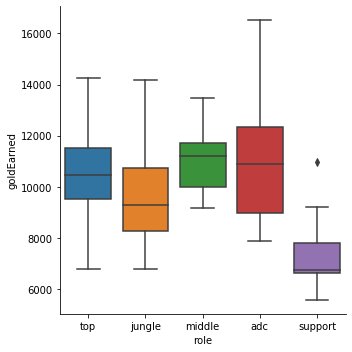

In [32]:
sns.catplot(x='role', y='goldEarned', kind='box', data=df)

In [17]:
# jungle_df = df[df['role']=='jungle']
# jungle_df.head(6)

,matchId,gameId,gameDuration,gameVersion,champion,assists,championName,level,damageSelfMitigated,deaths,...,jgCsBefore10Min,kda,kp,laneMinionsFirst10Minutes,teamBaronKills,teamElderDragonKills,teamRiftHeraldKills,turretPlatesTaken,visionScorePerMin,win
1,na1_4251735878,4251735878,1580,12.5,32,13,amumu,14,26560,6,...,68.0,3.50,0.68,0,1,0,2,3,0.74,1
6,na1_4251735878,4251735878,1580,12.5,64,6,leesin,12,14617,10,...,36.0,1.40,0.34,0,0,0,0,0,0.53,0
11,na1_4251687453,4251687453,1520,12.5,32,4,amumu,12,16588,6,...,52.0,0.67,0.11,0,0,0,0,0,0.53,0
16,na1_4251687453,4251687453,1520,12.5,48,10,trundle,14,23806,3,...,48.0,4.67,1.27,0,1,0,1,1,1.02,1
20,na1_4251692237,4251692237,1580,12.5,76,5,nidalee,13,12802,8,...,60.0,1.00,0.24,0,0,0,0,0,0.35,0
26,na1_4251692237,4251692237,1580,12.5,32,10,amumu,14,23004,2,...,72.0,8.00,0.89,3,0,0,1,2,1.07,1


In [35]:
# gb = df.groupby('role')
# gb.get_group('jungle')

,matchId,gameId,gameDuration,gameVersion,champion,assists,championName,level,damageSelfMitigated,deaths,...,jgCsBefore10Min,kda,kp,laneMinionsFirst10Minutes,teamBaronKills,teamElderDragonKills,teamRiftHeraldKills,turretPlatesTaken,visionScorePerMin,win
1,na1_4251735878,4251735878,1580,12.5,32,13,amumu,14,26560,6,...,68.0,3.50,0.68,0,1,0,2,3,0.74,1
6,na1_4251735878,4251735878,1580,12.5,64,6,leesin,12,14617,10,...,36.0,1.40,0.34,0,0,0,0,0,0.53,0
11,na1_4251687453,4251687453,1520,12.5,32,4,amumu,12,16588,6,...,52.0,0.67,0.11,0,0,0,0,0,0.53,0
16,na1_4251687453,4251687453,1520,12.5,48,10,trundle,14,23806,3,...,48.0,4.67,1.27,0,1,0,1,1,1.02,1
20,na1_4251692237,4251692237,1580,12.5,76,5,nidalee,13,12802,8,...,60.0,1.00,0.24,0,0,0,0,0,0.35,0
26,na1_4251692237,4251692237,1580,12.5,32,10,amumu,14,23004,2,...,72.0,8.00,0.89,3,0,0,1,2,1.07,1
31,na1_4251559492,4251559492,1626,12.5,131,0,diana,12,13482,9,...,52.0,0.00,0.00,0,0,0,0,0,0.66,0
36,na1_4251559492,4251559492,1626,12.5,121,5,khazix,16,13779,1,...,56.0,15.00,1.15,15,1,0,2,4,0.58,1
41,na1_4251386167,4251386167,1773,12.5,32,7,amumu,14,18619,2,...,49.5,4.50,0.82,10,2,0,1,0,1.14,1
46,na1_4251386167,4251386167,1773,12.5,876,1,lillia,14,10899,5,...,60.0,0.20,0.04,0,0,0,0,0,0.71,0
